In [1]:
%matplotlib inline

import os
from pathlib import Path

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

DATA_RAW = Path(os.getcwd()) / os.pardir / "data" / "raw" / "consumption"

# Datasets

 1. Training Conumption - `Given 1`
 2. Public Test set - `Given 2` (Note, contains all of Given 1 as well)
 3. Private Test set - `Series` (Note, contains Given 1 and Given 2 as well)
 4. Weather - `Weather`
 4. Building Metadata - `challenge-1-metadata-forecasting-energy-demand-in-buildings.csv`
 5. Public Holidays - `challenge-1-public-holidays-forecasting-energy-demand-in-building.csv`

In [2]:
!tree -L 2 $DATA_RAW

/Users/bull/schneider/data-preparation/../data/raw/consumption
├── Given1
│   └── Series
├── Given2
│   └── Series
├── Series
│   ├── 1.csv
│   ├── 10.csv
│   ├── 100.csv
│   ├── 101.csv
│   ├── 102.csv
│   ├── 105.csv
│   ├── 106.csv
│   ├── 107.csv
│   ├── 108.csv
│   ├── 109.csv
│   ├── 11.csv
│   ├── 110.csv
│   ├── 111.csv
│   ├── 112.csv
│   ├── 115.csv
│   ├── 116.csv
│   ├── 117.csv
│   ├── 118.csv
│   ├── 119.csv
│   ├── 12.csv
│   ├── 120.csv
│   ├── 121.csv
│   ├── 122.csv
│   ├── 123.csv
│   ├── 124.csv
│   ├── 125.csv
│   ├── 126.csv
│   ├── 127.csv
│   ├── 128.csv
│   ├── 129.csv
│   ├── 13.csv
│   ├── 130.csv
│   ├── 131.csv
│   ├── 132.csv
│   ├── 134.csv
│   ├── 135.csv
│   ├── 136.csv
│   ├── 139.csv
│   ├── 14.csv
│   ├── 140.csv
│   ├── 141.csv
│   ├── 142.csv
│   ├── 143.csv
│   ├── 145.csv
│   ├── 146.csv
│   ├── 148.csv
│   ├── 149.csv
│   ├── 15.csv
│   ├── 150.csv
│   ├── 151.csv
│   ├── 152.csv
│   ├── 153.csv
│   ├── 154.csv
│   ├── 155.csv
│   ├── 156.csv
│ 

# Dataset 1: Historical Consumption (Training)

Since the private set test, `Series` contains all of the data we will just load that and use it for further subdivision.

In [3]:
dfs = []

for f in (DATA_RAW / 'Series').glob('*.csv'):
    dfs.append(pd.read_csv(f, parse_dates=['Timestamp']))
    
consumption = pd.concat(dfs).sort_values(['SiteId', 'Timestamp'])

print(consumption.shape)
consumption.head()

(9640816, 4)


,SiteId,Timestamp,Value,To_Forecast
0,1,2014-09-02 09:30:00,45516.974085,Given
1,1,2014-09-02 10:30:00,32732.340194,Given
2,1,2014-09-02 11:30:00,75579.211274,Given
3,1,2014-09-02 12:30:00,57260.989024,Given
4,1,2014-09-02 13:30:00,47542.733444,Given


In [4]:
consumption.To_Forecast.value_counts()

Given         8037386
Forecast_1     801804
Forecast_2     801626
Name: To_Forecast, dtype: int64

In [5]:
consumption.dropna(subset=['Value']).To_Forecast.value_counts()

Given         7946511
Forecast_1     792321
Forecast_2     792199
Name: To_Forecast, dtype: int64

In [6]:
train_mask = consumption.To_Forecast == 'Given'
test_public_mask = consumption.To_Forecast == 'Forecast_2'
test_private_mask = consumption.To_Forecast == 'Forecast_1'

# first 10 percent null by site
(consumption[train_mask].groupby('SiteId')
                        .Value
                        .apply(lambda x: pd.isnull(x).sum() / x.shape[0])
                        .sort_values(ascending=False)).head(10)

SiteId
107    0.775556
64     0.436111
41     0.211111
20     0.202778
295    0.197778
294    0.197778
293    0.197778
260    0.197778
32     0.166667
272    0.142222
Name: Value, dtype: float64

In [7]:
# first 10 percent null by site
(consumption[test_private_mask].groupby('SiteId')
                        .Value
                        .apply(lambda x: pd.isnull(x).sum() / x.shape[0])
                        .sort_values(ascending=False)).head(10)

SiteId
107    0.616667
221    0.383333
99     0.300000
47     0.233333
266    0.216667
20     0.200000
279    0.116667
192    0.116667
134    0.109375
263    0.108333
Name: Value, dtype: float64

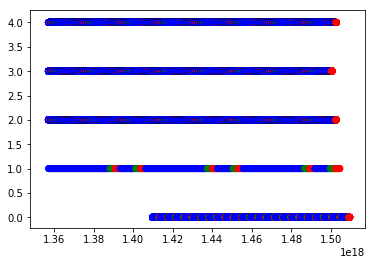

In [30]:
for i, site in enumerate(consumption.SiteId.unique()[:5]):

    to_plot = consumption[(consumption.SiteId == site)]
    
    plt.scatter(to_plot.Timestamp.astype(int),
                [i] * to_plot.shape[0],
                c=to_plot.To_Forecast.replace({'Forecast_1': 'g', 'Forecast_2': 'r', 'Given': 'b'}).values,
                alpha=0.5)

# Weather

In [34]:
dfs = []

for f in (DATA_RAW / 'Weather').glob('*.csv'):
    dfs.append(pd.read_csv(f, sep=';', parse_dates=['Timestamp']))
    
weather = pd.concat(dfs).sort_values(['SiteId', 'Timestamp'])

print(weather.shape)

(20017278, 4)


,Timestamp,Temperature,Distance,SiteId
78064,2014-01-01 00:00:00,-7.2,24.889929,1
86746,2014-01-01 00:00:00,-8.3,23.303097,1
90002,2014-01-01 00:00:00,-7.8,20.952256,1
90003,2014-01-01 00:00:00,-8.0,20.952256,1
100541,2014-01-01 00:34:00,-8.1,16.610602,1


In [43]:
", ".join(np.setdiff1d(consumption.SiteId.unique(), weather.SiteId.unique()).astype('str').tolist())

'11, 14, 15, 43, 53, 54, 60, 61, 64, 66, 69, 75, 78, 83, 85, 107, 111, 118, 136, 139, 141, 155, 158, 159, 173, 185, 186, 190, 191, 192, 195, 207, 208, 209, 210, 217, 222, 224, 225, 226, 228, 232, 238, 243, 247, 250, 259, 261, 266, 267, 280, 305'

In [40]:
weather[weather.SiteId == 11]

,Timestamp,Temperature,Distance,SiteId


In [46]:
weather.groupby('SiteId').agg({'Timestamp': ['min', 'max']})

Timestamp                    
                       min                 max
SiteId                                        
1      2014-01-01 00:00:00 2017-12-30 21:00:00
2      2013-01-01 00:00:00 2017-12-30 21:30:00
3      2013-01-01 00:00:00 2017-12-30 21:30:00
4      2013-01-01 00:00:00 2017-12-30 21:30:00
5      2013-01-01 00:00:00 2017-12-30 21:30:00
6      2013-01-01 00:00:00 2017-12-30 21:30:00
7      2015-01-01 00:00:00 2017-12-30 21:30:00
8      2013-01-01 00:00:00 2017-12-30 21:30:00
9      2013-01-01 00:00:00 2016-12-31 23:30:00
10     2013-01-01 00:00:00 2017-12-30 21:30:00
12     2016-01-01 00:00:00 2017-12-30 21:00:00
13     2014-01-01 00:15:00 2017-12-14 05:00:00
16     2014-01-01 00:15:00 2017-12-30 20:45:00
17     2014-05-15 02:53:00 2017-10-01 05:53:00
18     2014-05-15 02:53:00 2017-10-01 05:53:00
19     2015-01-01 00:00:00 2017-12-30 21:30:00
20     2015-01-01 00:00:00 2017-12-30 21:15:00
21     2014-01-01 00:00:00 2017-12-17 21:00:00
22     2014-01-01 00:00:00 2017-12-30 21:30:00
23     2014-01-01 00:00:00 2016-12-31 23:50:00
24     2014-01-01 00:00:00 2017-12-17 21:00:00
25     2014-01-01 00:00:00 2017-12-30 21:20:00
26     2014-01-01 00:58:00 2017-12-30 21:00:00
27     2014-01-01 06:00:00 2017-12-30 14:50:00
28     2014-01-01 00:00:00 2017-12-30 21:20:00
29     2015-01-01 00:00:00 2017-12-30 21:20:00
30     2015-01-01 00:00:00 2017-12-30 21:30:00
32     2015-01-01 00:00:00 2017-12-20 21:30:00
33     2014-01-01 00:00:00 2017-12-17 21:00:00
34     2015-01-01 00:00:00 2017-12-30 21:30:00
...                    ...                 ...
274    2013-01-01 00:20:00 2017-12-30 21:20:00
275    2014-01-01 00:20:00 2017-12-30 21:20:00
276    2014-07-01 06:00:00 2017-12-30 21:00:00
277    2014-01-01 00:00:00 2017-12-30 21:20:00
278    2013-01-01 00:20:00 2017-12-30 21:20:00
279    2013-01-01 00:50:00 2017-12-30 20:50:00
281    2013-01-01 00:20:00 2017-12-30 21:20:00
282    2013-01-01 00:20:00 2017-12-30 21:20:00
283    2015-01-01 00:00:00 2017-12-30 21:00:00
284    2015-01-01 00:00:00 2017-12-30 21:00:00
285    2016-01-01 00:00:00 2017-12-30 21:20:00
286    2014-01-01 00:00:00 2017-12-30 21:20:00
287    2014-01-01 06:00:00 2017-12-30 14:50:00
288    2016-01-01 00:00:00 2017-12-30 21:30:00
289    2015-01-01 00:00:00 2017-12-30 21:20:00
290    2009-01-01 00:00:00 2017-12-30 21:00:00
291    2016-01-01 00:00:00 2017-12-30 21:20:00
292    2015-01-01 00:00:00 2017-12-17 21:00:00
293    2015-01-01 00:00:00 2017-12-17 21:00:00
294    2015-01-01 00:00:00 2017-12-17 21:00:00
295    2015-01-01 00:00:00 2017-12-17 21:00:00
296    2015-01-01 00:20:00 2017-12-30 21:20:00
297    2009-01-01 00:00:00 2017-12-30 21:00:00
298    2014-01-01 05:05:00 2017-12-30 19:50:00
299    2015-01-01 05:50:00 2017-12-30 19:50:00
300    2015-01-01 00:00:00 2017-12-30 21:20:00
301    2009-01-01 00:00:00 2017-12-30 21:00:00
302    2009-01-01 00:00:00 2017-12-30 21:00:00
303    2009-01-01 00:00:00 2017-12-30 21:00:00
304    2015-01-01 00:00:00 2017-12-19 21:20:00

[247 rows x 2 columns]

In [56]:
a = consumption.groupby('SiteId').Timestamp.agg(['min', 'max']).sort_values('max', ascending=False)

a['max'].min(), a['min'].max()

(Timestamp('2014-07-23 01:00:00'), Timestamp('2016-06-19 06:45:00'))

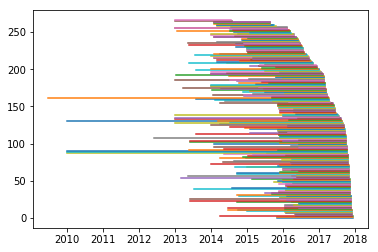

In [58]:
for i, row in enumerate(a.iterrows()):
    site, times = row
    plt.plot([times['min'], times['max']],
             [i]*2)

In [72]:
tmin = pd.to_datetime('2016-06-01')
tmax = pd.to_datetime('2017-09-01')

a[(a['max'] >= tmax) & (a['min'] <= tmin)].shape

(120, 2)

In [ ]:
'{}'

In [79]:
# for yr in range(2014, 2018):
#     for mo in range(1, 13):
#         tests.append(pd.to_datetime("{}-{}-01".format(yr, mo)))
        
tests = pd.date_range(start='2015-06-01', end='2018-01-01', freq='1M')
        
#         print(yr, mo, a[(a['min'] <= test) & (a['max'] >= test)].shape)

In [94]:
n_sites = []

for start in tests:
    for end in tests:
        if end <= start:
            continue
        
        # ends after end
        end_test = a['max'] >= end
        
        # starts before start
        start_test = a['min'] <= start
        
        
        n_sites.append((start,
                        end,
                        a[start_test & end_test].shape[0],
                        end - start
                       ))

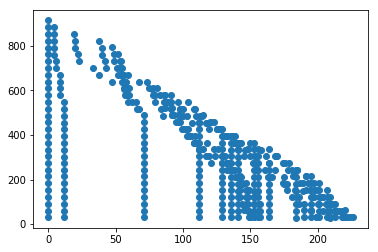

In [100]:
tests = pd.DataFrame(n_sites).sort_values(2, ascending=False)

plt.scatter(tests[2], tests[3].dt.days)

In [111]:
# (tests[2] * tests[3].dt.days).sort_values(ascending=False)

# tests.iloc[229]

0    2017-04-30 00:00:00
1    2017-08-31 00:00:00
2                    129
3      123 days 00:00:00
Name: 432, dtype: object

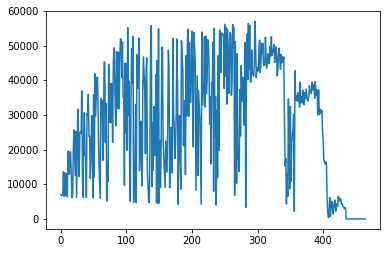

In [112]:
plt.plot(np.arange(tests.shape[0]), (tests[3].dt.days * tests[2])) #.sort_values(ascending=False)


In [118]:
(tests[3].dt.days * tests[2]).iloc[325:375]

230    50373
75     45153
17     47850
183    49708
47     47300
129    41310
103    43428
18     48223
184    49329
158    45662
76     43213
159    47502
48     45084
208    46816
19     45675
160    46720
357    28116
426    15194
417    17395
456     4331
434    13064
452     6532
309    34648
407    19383
447     8733
326    32447
441    10863
396    21584
384    23785
371    25915
342    30246
459     2201
185    42813
291    34706
130    34122
104    35620
272    34038
49     36540
77     34680
131    32273
161    39530
132    33524
133    35264
105    33524
20     37120
107    36423
252    33003
134    36423
106    34713
108    37520
dtype: int64

In [119]:
tests.loc[160]

0    2015-11-30 00:00:00
1    2017-08-31 00:00:00
2                     73
3      640 days 00:00:00
Name: 160, dtype: object

# Metadata

In [125]:
meta_data = pd.read_csv(DATA_RAW / 'challenge-1-metadata-forecasting-energy-demand-in-buildings.csv', sep=';')

np.setdiff1d(consumption.SiteId.unique(), meta_data.SiteId)

array([], dtype=int64)

# Holidays

In [131]:
holidays = pd.read_csv(DATA_RAW / 'challenge-1-public-holidays-forecasting-energy-demand-in-building.csv', sep=';')

", ".join(np.setdiff1d(consumption.SiteId.unique(), holidays.SiteId.unique()).astype('str'))

'2, 3, 5, 6, 7, 8, 9, 10, 11, 19, 38, 41, 219, 232, 233, 234, 235, 236, 261, 262, 263, 264, 265, 266, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 289'